In [2]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from keras.src.models import Sequential
from keras.src.layers import Embedding, LSTM, Dense, Dropout
from keras.src.utils import to_categorical

In [3]:
data = pd.read_csv(r"C:\Users\KIIT\PyCharmProjects\HateSpeechDetection\data\train.csv")

data.head()

,count,hate_speech_count,offensive_language_count,neither_count,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [4]:
print(f"num of tweets: {data.shape}")
tweet = list(data['tweet'])
labels = list(data['class'])

num of tweets: (24783, 6)


In [6]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
stop_words.add("rt")


def remove_entity(raw_text):
    entity_regex = r"&[^\s;]+;"
    text = re.sub(entity_regex, "", raw_text)
    return text


def change_user(raw_text):
    regex = r"@([^ ]+)"
    text = re.sub(regex, "user", raw_text)

    return text


def remove_url(raw_text):
    url_regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    text = re.sub(url_regex, '', raw_text)

    return text


def remove_noise_symbols(raw_text):
    text = raw_text.replace('"', '')
    text = text.replace("'", '')
    text = text.replace("!", '')
    text = text.replace("`", '')
    text = text.replace("..", '')

    return text


def remove_stopwords(raw_text):
    tokenize = nltk.word_tokenize(raw_text)
    text = [word for word in tokenize if not word.lower() in stop_words]
    text = " ".join(text)

    return text


def preprocess(datas):
    clean = []
    clean = [change_user(text) for text in datas]
    clean = [remove_entity(text) for text in clean]
    clean = [remove_url(text) for text in clean]
    clean = [remove_noise_symbols(text) for text in clean]
    clean = [remove_stopwords(text) for text in clean]
    return clean

In [7]:
import nltk

nltk.download('punkt_tab')
clean_tweet = preprocess(tweet)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\KIIT\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [8]:
X_train, X_test, y_train, y_test = train_test_split(clean_tweet, labels, test_size=0.2, random_state=42)

In [9]:
from keras.src.legacy.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

In [10]:
from keras.src.utils import pad_sequences

max_length = max(len(seq) for seq in X_train)

for x in X_test:
    if len(x) > max_length:
        print(f"an outlier detected: {x}")

X_train = pad_sequences(X_train, maxlen=max_length)
X_test = pad_sequences(X_test, maxlen=max_length)

In [11]:
y_test = to_categorical(y_test, num_classes=3)
y_train = to_categorical(y_train, num_classes=3)

In [12]:
print(f"num test tweet: {y_test.shape[0]}")
print(f"num train tweet: {y_train.shape[0]}")

num test tweet: 4957
num train tweet: 19826


In [13]:
import tensorflow.keras.backend as K

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def f1(y_true, y_pred):
    precisions = precision(y_true, y_pred)
    recalls = recall(y_true, y_pred)
    return 2 * ((precisions * recalls) / (precisions + recalls + K.epsilon()))


In [14]:
output_dim = 200

model = Sequential([
    Embedding(vocab_size, output_dim, input_length=max_length),
    LSTM(64, dropout=0.3, recurrent_dropout=0.3),
    Dropout(0.5),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(3, activation="softmax"),
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1, precision, recall])

C:\Users\KIIT\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [16]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (19826, 26)
y_train shape: (19826, 3)
X_test shape: (4957, 26)
y_test shape: (4957, 3)


In [17]:
if X_test is None or y_test is None:
    raise ValueError("X_test or y_test is None. Check data loading.")

In [18]:
X_train = X_train.reshape((X_train.shape[0], -1))
X_test = X_test.reshape((X_test.shape[0], -1))

In [19]:
model_history = model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=10,
    validation_data=(X_test, y_test)
)

Epoch 1/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 36s 95ms/step - accuracy: 0.7850 - f1: 0.7036 - loss: 0.6228 - precision: 0.7631 - recall: 0.6803 - val_accuracy: 0.8854 - val_f1: 0.8860 - val_loss: 0.3348 - val_precision: 0.9068 - val_recall: 0.8665
Epoch 2/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 28s 90ms/step - accuracy: 0.9162 - f1: 0.9163 - loss: 0.2716 - precision: 0.9293 - recall: 0.9038 - val_accuracy: 0.8862 - val_f1: 0.8846 - val_loss: 0.3313 - val_precision: 0.8991 - val_recall: 0.8709
Epoch 3/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step - accuracy: 0.9407 - f1: 0.9400 - loss: 0.1694 - precision: 0.9480 - recall: 0.9322 - val_accuracy: 0.8810 - val_f1: 0.8811 - val_loss: 0.3766 - val_precision: 0.8869 - val_recall: 0.8755
Epoch 4/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 20s 64ms/step - accuracy: 0.9628 - f1: 0.9624 - loss: 0.1109 - precision: 0.9653 - recall: 0.9596 - val_accuracy: 0.8751 - val_f1: 0.8750 - val_loss: 0.4668 - val_precision: 0.8781 - val_recall: 0.8721
Epoch 5/10
310/310 ━━━━━━━━━━━━━

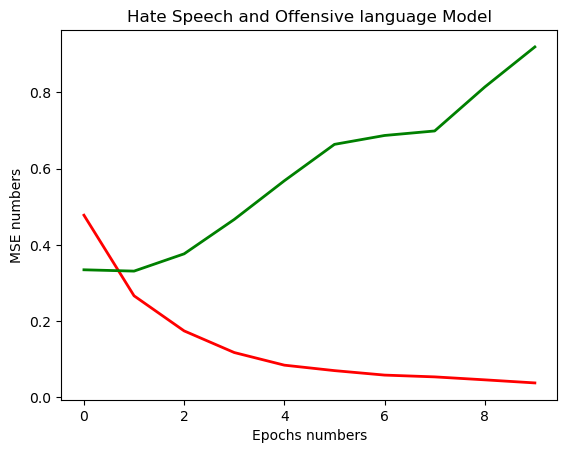

In [20]:
import matplotlib.pyplot as plt

hist = model.history.history
plt.plot(hist['loss'], 'r', linewidth=2, label='Training loss')
plt.plot(hist['val_loss'], 'g', linewidth=2, label='Validation loss')
plt.title('Hate Speech and Offensive language Model')
plt.xlabel('Epochs numbers')
plt.ylabel('MSE numbers')
plt.show()

In [38]:
import numpy as np

custom_sentence = ["i love you"]

custom_sequence = tokenizer.texts_to_sequences(custom_sentence)
custom_padded = pad_sequences(custom_sequence, maxlen=max_length)

prediction = model.predict(custom_padded)
predicted_class = np.argmax(prediction)
confidence = prediction[0][predicted_class]

print(custom_sentence)
print(confidence)
if prediction[0][2] < 0.9:
    print("NOT Hate Speech")
elif prediction[0][1] > 0.99:
    print("Offensive Language")
else:
    print("Hate Speech")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
['i love you']
0.979389
NOT Hate Speech


In [39]:
import numpy as np

custom_sentence = ["i hate you"]

custom_sequence = tokenizer.texts_to_sequences(custom_sentence)
custom_padded = pad_sequences(custom_sequence, maxlen=max_length)

prediction = model.predict(custom_padded)
predicted_class = np.argmax(prediction)
confidence = prediction[0][predicted_class]

print(custom_sentence)
print(confidence)
if prediction[0][2] > 0.9:
    print("NOT Hate Speech")
elif prediction[0][1] > 0.99:
    print("Offensive Language")
else:
    print("Hate Speech")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
['i hate you']
0.51306224
Hate Speech
